# Can player age and experience predict a player's total hours spent in game?
Group 005-1 - Emily Ung, Owen Hochwald, Jasmine Kaur, Mariah Fang

# Introduction

In collaboration with a research group at UBC led by Frank Wood, this project aims to use data to make predictions about how people play video games, specifically, Minecraft. As the researchers want to recruit players who will contribute large amounts of data, the question we will address is whether the age and experience level of a player can predict their total hours spent in game. The data provided by the research group consists of two datasets: players and sessions. For the purpose of this project, we will be using the players dataset.

The players dataset lists all individual players, as well as information for each individual. It has 196 observations, meaning there are 196 individual players. The 7 variables are as follows:

- experience (character variable): A variable describing the player's past experience with the game. Players are categorized from Beginner to Pro levels of experience. 
- subscribe (logical variable): A variable indicating whether or not the player is subscribed to a game-related newsletter.
- hashedEmail (character variable): A variable that records the individual encrypted email address of the player. 
- played_hours (double variable): The total amount of hours the player has spent in game.
- name (character variable): The player's name.
- gender (character variable): The player's gender.
- Age (double variable): The player's age, in years.

To predict a player's in-game hours, we will use regression with a K-nearest neighbours approach. The predictor variables are the age and experience level of the player. We will split our data into training and testing datasets, use cross-validation to choose the k value, and then make predictions on the test data. Regression is a method in data science used to predict numeric values (in-game hours). Knn also has the advantage of not requiring the data to look a certain way or to be linear. 

Using the categories of players based on experience level (experience) and age (Age), we can predict if different types of players spend different amounts of time in game (played_hours), and thus, if they will contribute different amounts of data. 


# Methods & Results

## Data Wrangling Plan:
- Clean column names.
- Drop irrelevant columns.
- Convert experience & gender to factor columns.
- Drop NA values.
-  Normalize data.

### Importing Libraries

In [1]:
# loading libraries
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(repr)
library(janitor)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Loading Data

In [2]:
# loading data
players <- read_csv('https://raw.githubusercontent.com/owenHochwald/DSCI-Project-Data/refs/heads/main/players.csv')

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Preprocessing

In [3]:
# wrangling data
players_clean <- players |>
                clean_names() |>
                select(age, experience, played_hours) |>
                mutate(experience = as_factor(experience)) |>
                drop_na()
players_clean

age,experience,played_hours
<dbl>,<fct>,<dbl>
9,Pro,30.3
17,Veteran,3.8
17,Veteran,0.0
⋮,⋮,⋮
22,Veteran,0.3
17,Amateur,0.0
17,Amateur,2.3


### Summary Statistics

In [4]:
players_mean <- players_clean |>
        select(played_hours, age) |>
        map_df(mean)

players_mean

played_hours,age
<dbl>,<dbl>
5.904639,20.52062


In [5]:
summary(players_clean)

      age           experience  played_hours    
 Min.   : 8.00   Pro     :13   Min.   :  0.000  
 1st Qu.:17.00   Veteran :48   1st Qu.:  0.000  
 Median :19.00   Amateur :63   Median :  0.100  
 Mean   :20.52   Regular :35   Mean   :  5.905  
 3rd Qu.:22.00   Beginner:35   3rd Qu.:  0.600  
 Max.   :50.00                 Max.   :223.100  

### Visualizations

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


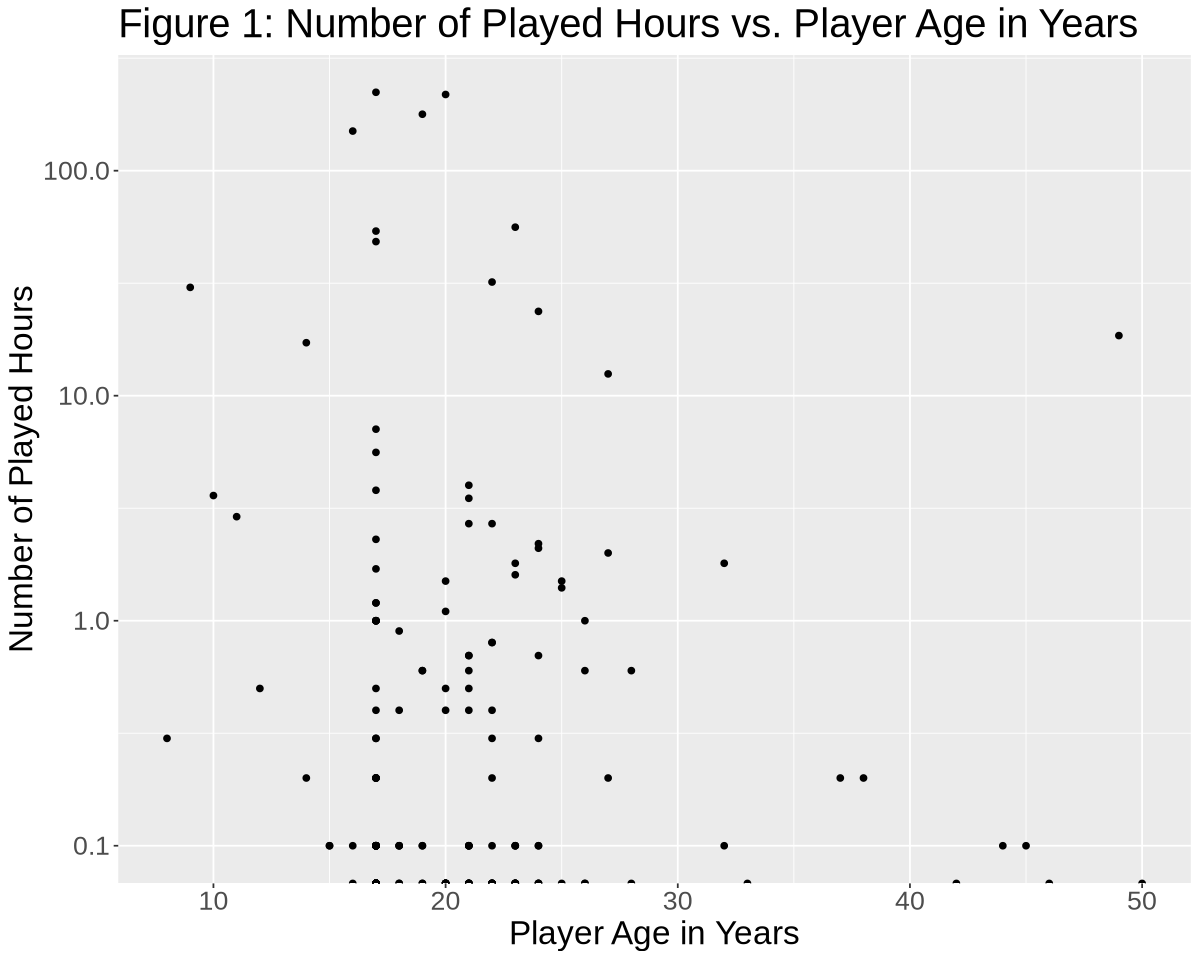

In [6]:
options(repr.plot.width=10, repr.plot.height=8)

ggplot(players_clean, aes(x=age, y=played_hours)) +
        geom_point() +
        xlab("Player Age in Years") +
        scale_y_log10() +
        ylab("Number of Played Hours") +
        theme(text=element_text(size=20)) +
        ggtitle("Figure 1: Number of Played Hours vs. Player Age in Years")

       

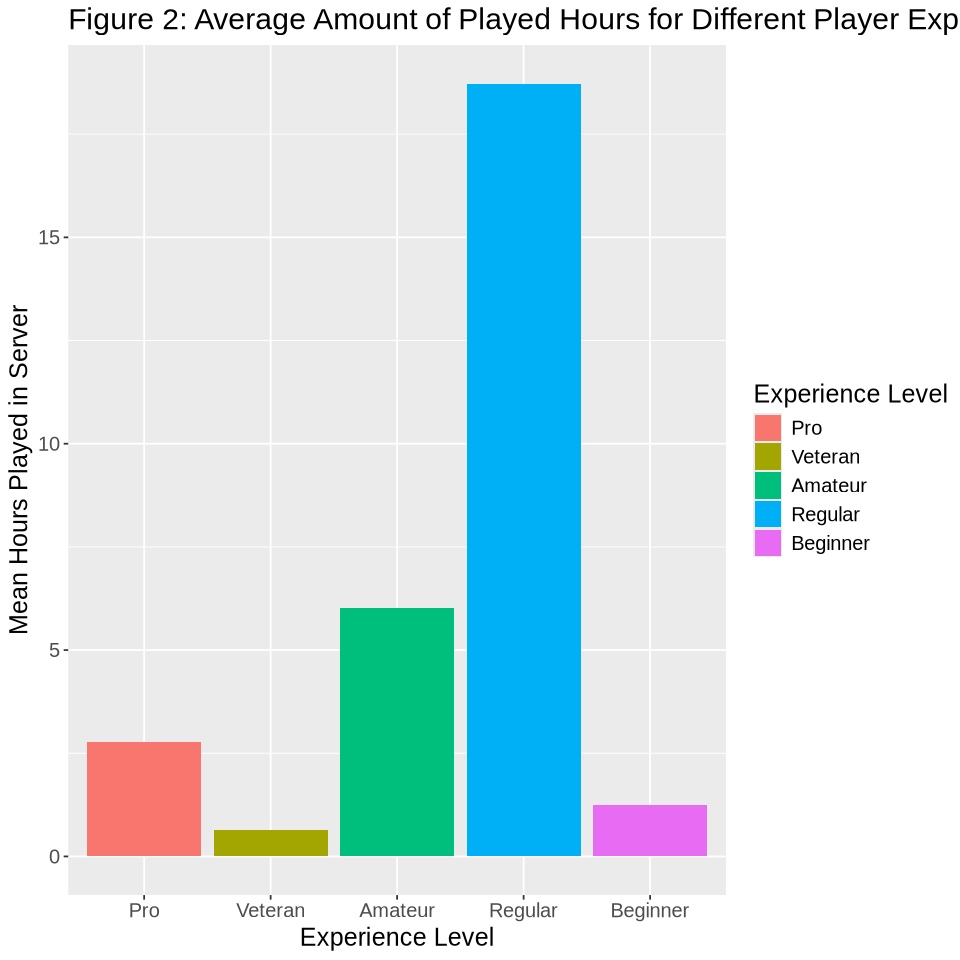

In [7]:
options(repr.plot.width=8, repr.plot.height=8)


exp_means <- players_clean |>
    group_by(experience) |>
    summarize(mean_played_hours = mean(played_hours))

exp_plot <- exp_means |>
    ggplot(aes(x = experience, y= mean_played_hours, fill=experience)) +
    geom_bar(stat = "identity") +
    xlab("Experience Level") +
    ylab("Mean Hours Played in Server") +
    ggtitle("Figure 2: Average Amount of Played Hours for Different Player Expierence Levels") +
    labs(fill="Experience Level") +
    theme(text = element_text(size=15))

exp_plot

### Creating split

In [8]:
set.seed(42)
split <- initial_split(players_clean, prop = 0.8, strata = played_hours)
players_train <- training(split)
players_testing <- testing(split)

### Hyperparameter Tuning

Optimal number of neighbors is k = 9

In [9]:
set.seed(42)
knn_recipe <- recipe(played_hours ~., data=players_train) |>
    step_center(age) |>
    step_scale(age) 

knn_model <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
    set_engine("kknn") |>
    set_mode("regression") 

k_vals <- tibble(neighbors = seq(from=1,to=10, by=1))

val <- vfold_cv(players_train, v=5, strata=played_hours)

find_k <- workflow() |>
    add_model(knn_model) |>
    add_recipe(knn_recipe) |>
    tune_grid(resample = val, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    filter(mean == min(mean))


find_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,rmse,standard,28.51499,5,5.898581,Preprocessor1_Model09


### Retraining Model with new K

In [10]:
knn_model <- nearest_neighbor(weight_func="rectangular", neighbors=9) |>
    set_engine("kknn") |>
    set_mode("regression") 

knn_fit <- workflow() |>
    add_model(knn_model) |>
    add_recipe(knn_recipe) |>
    fit(data=players_train)

In [11]:
hours_summary <- knn_fit |>
  predict(players_testing) |>
  bind_cols(players_testing) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')
hours_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,18.20708


### Visualizing Analysis

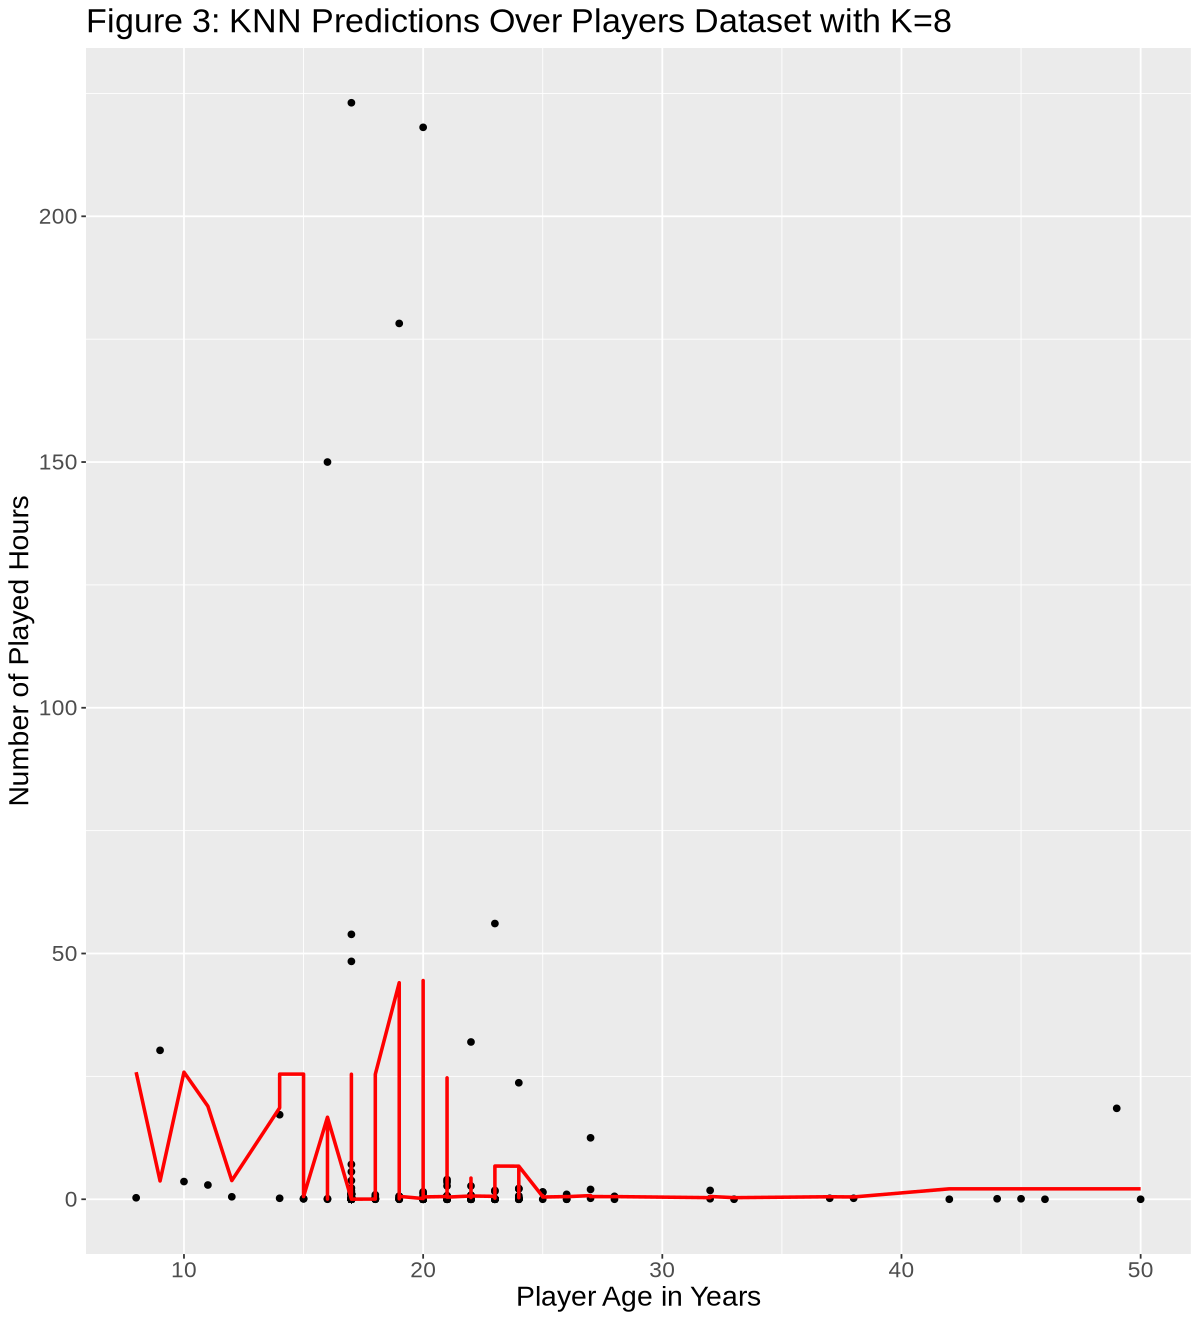

In [12]:
options(repr.plot.width=10, repr.plot.height=11)

players_preds <- knn_fit |>
  predict(players_clean) |>
  bind_cols(players_clean) 

plot_final <- ggplot(players_preds, aes(x = age, y = played_hours)) +
  geom_point() +
  geom_line(data = players_preds,
            mapping = aes(x = age, y = .pred),
            color = "red",
            linewidth = 1) +
  xlab("Player Age in Years") +
  ylab("Number of Played Hours") +
  ggtitle("Figure 3: KNN Predictions Over Players Dataset with K=8") +
  theme(text = element_text(size = 17))

plot_final

# Discussion